In [28]:
# Restart with claude
%pip install --upgrade scikit-learn imbalanced-learn
%pip install seaborn




  Using cached scikit_learn-1.7.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [8]:
file_path = r"C:\Users\ElifYilmaz\Downloads\lead_time.csv"

df = pd.read_csv(file_path)

In [9]:

def engineer_lead_conversion_features(df):
    """
    Comprehensive feature engineering for lead conversion prediction
    
    Args:
        df: DataFrame with lead data following the specified structure
        
    Returns:
        df_features: DataFrame with engineered features
    """
    
    # Create a copy to avoid modifying original data
    df_features = df.copy()
    
    # Convert date columns to datetime
    date_columns = ['LEAD_CREATION_DATE', 'SC1_SCHEDULED', 'SC1_APPOINTMENT', 
                   'LAST_FU', 'NEXT_FU', 'CONTRACT_SIGNED', 'WITHDRAWAL', 
                   'IPA_SCHEDULED', 'IPA_DAY']
    
    for col in date_columns:
        if col in df_features.columns:
            df_features[col] = pd.to_datetime(df_features[col], errors='coerce')
    
    # BC date columns
    bc_date_cols = [f'BC_{i}' for i in range(1, 19)]
    for col in bc_date_cols:
        if col in df_features.columns:
            df_features[col] = pd.to_datetime(df_features[col], errors='coerce')
    
    # BC outcome columns
    bc_outcome_cols = [f'BC_{i}_OUTCOME' for i in range(1, 19)]
    
    print("Creating booking call efficiency features...")
    
    # 1. BOOKING CALL EFFICIENCY FEATURES
    # Count total BC attempts (non-null BC dates)
    bc_dates = df_features[bc_date_cols].copy()
    df_features['total_bc_attempts'] = bc_dates.notna().sum(axis=1)
    
    # Count total BC outcomes (non-null outcomes)
    bc_outcomes = df_features[bc_outcome_cols].copy()
    df_features['total_bc_outcomes'] = bc_outcomes.notna().sum(axis=1)
    
    # First and last BC attempt dates
    df_features['first_bc_date'] = bc_dates.min(axis=1)
    df_features['last_bc_date'] = bc_dates.max(axis=1)
    
    print("Creating temporal features...")
    
    # 2. TEMPORAL FEATURES
    # Days from lead creation to first BC
    df_features['lead_to_first_bc_days'] = (
        df_features['first_bc_date'] - df_features['LEAD_CREATION_DATE']
    ).dt.days
    
    # Days from first BC to last BC (booking call duration)
    df_features['bc_duration_days'] = (
        df_features['last_bc_date'] - df_features['first_bc_date']
    ).dt.days
    
    # Days from lead creation to SC1 scheduled
    df_features['lead_to_sc1_days'] = (
        df_features['SC1_SCHEDULED'] - df_features['LEAD_CREATION_DATE']
    ).dt.days
    
    # Days from SC1 scheduled to appointment
    df_features['sc1_schedule_to_appointment_days'] = (
        df_features['SC1_APPOINTMENT'] - df_features['SC1_SCHEDULED']
    ).dt.days
    
    # BC call frequency (attempts per day during BC period)
    df_features['bc_frequency'] = np.where(
        df_features['bc_duration_days'] > 0,
        df_features['total_bc_attempts'] / (df_features['bc_duration_days'] + 1),
        df_features['total_bc_attempts']  # If same day, frequency = total attempts
    )
    
    print("Creating engagement quality features...")
    
    # 3. ENGAGEMENT QUALITY FEATURES
    # Define outcome categories
    positive_outcomes = ['VDTOPLAN', 'REACHED', 'CONFIRMED', 'INTERESTED']
    negative_outcomes = ['LOST', 'NOTINTERESTED', 'UNQUALIFIED']
    neutral_outcomes = ['TOBERECALLED', 'RESCHEDULE']
    unreachable_outcomes = ['NOTREACHED', 'NOANSWER', 'VOICEMAIL']
    noshow_outcomes = ['NOSHOW', 'NOSHOWNOTREACHED', 'NOSHOWLOST', 'NOSHOWVDTOPLAN', 'NOSHOWTOBERECALLED']
    
    # Count outcomes by category
    def count_outcome_category(row, category_list):
        count = 0
        for col in bc_outcome_cols:
            if col in row.index and pd.notna(row[col]):
                if any(cat.upper() in str(row[col]).upper() for cat in category_list):
                    count += 1
        return count
    
    df_features['positive_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, positive_outcomes), axis=1
    )
    
    df_features['negative_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, negative_outcomes), axis=1
    )
    
    df_features['noshow_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, noshow_outcomes), axis=1
    )
    
    df_features['unreachable_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, unreachable_outcomes), axis=1
    )
    
    # Calculate ratios (avoid division by zero)
    total_outcomes = df_features['total_bc_outcomes']
    df_features['positive_outcome_ratio'] = np.where(
        total_outcomes > 0, 
        df_features['positive_outcomes_count'] / total_outcomes, 
        0
    )
    
    df_features['negative_outcome_ratio'] = np.where(
        total_outcomes > 0,
        df_features['negative_outcomes_count'] / total_outcomes,
        0
    )
    
    df_features['noshow_outcome_ratio'] = np.where(
        total_outcomes > 0,
        df_features['noshow_outcomes_count'] / total_outcomes,
        0
    )
    
    df_features['reachability_score'] = np.where(
        total_outcomes > 0,
        1 - (df_features['unreachable_outcomes_count'] / total_outcomes),
        0
    )
    
    print("Creating behavioral pattern features...")
    
    # 4. BEHAVIORAL PATTERN FEATURES
    # Last BC outcome (most recent attempt result)
    def get_last_bc_outcome(row):
        for i in range(18, 0, -1):  # Check from BC_18 down to BC_1
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                return row[col]
        return 'NO_OUTCOME'
    
    df_features['last_bc_outcome'] = df_features.apply(get_last_bc_outcome, axis=1)
    
    # First BC outcome
    def get_first_bc_outcome(row):
        for i in range(1, 19):  # Check from BC_1 to BC_18
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                return row[col]
        return 'NO_OUTCOME'
    
    df_features['first_bc_outcome'] = df_features.apply(get_first_bc_outcome, axis=1)
    
    # Outcome improvement/deterioration pattern
    def outcome_trend(row):
        outcomes = []
        for i in range(1, 19):
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                # Score outcomes (higher = better)
                if any(pos.upper() in str(row[col]).upper() for pos in positive_outcomes):
                    outcomes.append(3)
                elif any(neu.upper() in str(row[col]).upper() for neu in neutral_outcomes):
                    outcomes.append(2)
                elif any(unr.upper() in str(row[col]).upper() for unr in unreachable_outcomes):
                    outcomes.append(1)
                else:
                    outcomes.append(0)  # negative outcomes
        
        if len(outcomes) < 2:
            return 0  # No trend
        
        # Calculate trend (positive = improving, negative = deteriorating)
        return outcomes[-1] - outcomes[0]
    
    df_features['outcome_trend'] = df_features.apply(outcome_trend, axis=1)
    
    # Persistence score (attempts after first negative outcome)
    def persistence_score(row):
        first_negative_pos = None
        total_after_negative = 0
        
        for i in range(1, 19):
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                if first_negative_pos is None and any(neg.upper() in str(row[col]).upper() for neg in negative_outcomes):
                    first_negative_pos = i
                elif first_negative_pos is not None:
                    total_after_negative += 1
        
        return total_after_negative
    
    df_features['persistence_after_negative'] = df_features.apply(persistence_score, axis=1)
    
    print("Creating conversion-related features...")
    
    # 5. CONVERSION-RELATED FEATURES
    # Binary target
    df_features['converted'] = df_features['CONTRACT_SIGNED'].notna().astype(int)
    
 
    # Show-up for SC1 appointment
    df_features['showed_up_sc1'] = df_features['SC1_APPOINTMENT'].notna().astype(int)
    
    print("Creating composite scores...")
    
    # 6. COMPOSITE SCORES
    # Overall engagement score (weighted combination)
    df_features['engagement_score'] = (
        0.3 * df_features['positive_outcome_ratio'] + 
        0.2 * df_features['reachability_score'] + 
        0.2 * (1 - df_features['negative_outcome_ratio']) +
        0.1 * (1 - df_features['noshow_outcome_ratio']) +
        0.1 * np.clip(df_features['bc_frequency'], 0, 5) / 5 +  # Cap frequency at 5
        0.1 * np.clip(df_features['outcome_trend'], -3, 3) / 6  # Normalize trend
    )
    
    # Efficiency score (quick to schedule with few attempts)
    df_features['efficiency_score'] = np.where(
        df_features['total_bc_attempts'] > 0,
        1 / (1 + df_features['total_bc_attempts']),  # Inverse of attempts
        0
    )
    
    print("Cleaning up features...")
    
    # Fill NaN values in temporal features
    temporal_features = [
        'lead_to_first_bc_days', 'bc_duration_days', 'lead_to_sc1_days',
        'sc1_schedule_to_appointment_days', 'bc_frequency'
    ]
    
    for feature in temporal_features:
        if feature in df_features.columns:
            df_features[feature] = df_features[feature].fillna(0)
    
    print("Feature engineering completed!")
    
    # Return only the engineered features (remove original columns for cleaner output)
    feature_columns = [
        'ID', 'converted',  # Keep ID and target
        # Booking call efficiency
        'total_bc_attempts', 'total_bc_outcomes',
        # Temporal features
        'lead_to_first_bc_days', 'bc_duration_days', 'lead_to_sc1_days',
        'sc1_schedule_to_appointment_days', 'bc_frequency',
        # Engagement quality
        'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count',
        'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score',
        # Behavioral patterns
        'last_bc_outcome', 'first_bc_outcome', 'outcome_trend', 'persistence_after_negative',
        # Conversion related
        'showed_up_sc1',
        # Composite scores
        'engagement_score', 'efficiency_score'
    ]
    
    return df_features[feature_columns]

# Example usage:
# df_features = engineer_lead_conversion_features(df_raw)
# print(f"Created {df_features.shape[1]} features for {df_features.shape[0]} leads")
# print(f"Conversion rate: {df_features['converted'].mean():.3f}")

In [10]:
# Example usage:
df_features = engineer_lead_conversion_features(df)
print(f"Created {df_features.shape[1]} features for {df_features.shape[0]} leads")
print(f"Conversion rate: {df_features['converted'].mean():.3f}")

Creating booking call efficiency features...
Creating temporal features...
Creating engagement quality features...
Creating behavioral pattern features...
Creating conversion-related features...
Creating composite scores...
Cleaning up features...
Feature engineering completed!
Created 23 features for 38367 leads
Conversion rate: 0.013


In [11]:

# Basic info about what we created
print(f"Shape: {df_features.shape}")
print(f"Conversion rate: {df_features['converted'].mean():.4f}")
print("\nFeature columns:")
print(df_features.columns.tolist())

Shape: (38367, 23)
Conversion rate: 0.0128

Feature columns:
['ID', 'converted', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'lead_to_sc1_days', 'sc1_schedule_to_appointment_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'last_bc_outcome', 'first_bc_outcome', 'outcome_trend', 'persistence_after_negative', 'showed_up_sc1', 'engagement_score', 'efficiency_score']


In [12]:
# Look at basic stats for a few key features
key_features = ['total_bc_attempts', 'total_bc_outcomes', 'lead_to_sc1_days', 'engagement_score']

print("Basic statistics for key features:")
print(df_features[key_features].describe())

print(f"\nConversions: {df_features['converted'].sum()} out of {len(df_features)}")

Basic statistics for key features:
       total_bc_attempts  total_bc_outcomes  lead_to_sc1_days  \
count       38367.000000       38367.000000      38367.000000   
mean            3.417051           3.417051          0.516616   
std             2.942957           2.942957          3.159240   
min             0.000000           0.000000         -7.000000   
25%             1.000000           1.000000          0.000000   
50%             2.000000           2.000000          0.000000   
75%             6.000000           6.000000          0.000000   
max            18.000000          18.000000        124.000000   

       engagement_score  
count      38367.000000  
mean           0.587071  
std            0.142167  
min            0.300000  
25%            0.520000  
50%            0.551270  
75%            0.690000  
max            0.900000  

Conversions: 490 out of 38367


In [13]:
# Compare converters vs non-converters on a few key features
print("Converters vs Non-converters:")
comparison = df_features.groupby('converted')[['total_bc_attempts', 'engagement_score', 'lead_to_sc1_days']].mean()
print(comparison)

Converters vs Non-converters:
           total_bc_attempts  engagement_score  lead_to_sc1_days
converted                                                       
0                   3.436069          0.585795          0.511102
1                   1.946939          0.685712          0.942857


In [14]:
# Check for missing values and extreme outliers
print("Missing values:")
print(df_features.isnull().sum()[df_features.isnull().sum() > 0])

print("\nFeatures with extreme values to check:")
print("Total BC attempts > 15:", (df_features['total_bc_attempts'] > 15).sum())
print("Lead to SC1 days > 30:", (df_features['lead_to_sc1_days'] > 30).sum())
print("Engagement score = 0.3 (minimum):", (df_features['engagement_score'] == 0.3).sum())

Missing values:
Series([], dtype: int64)

Features with extreme values to check:
Total BC attempts > 15: 77
Lead to SC1 days > 30: 82
Engagement score = 0.3 (minimum): 0


In [15]:
# Check the categorical feature
print("Last BC outcome categories:")
print(df_features['last_bc_outcome'].value_counts().head(10))

print(f"\nTotal unique outcomes: {df_features['last_bc_outcome'].nunique()}")

Last BC outcome categories:
last_bc_outcome
VDTOPLAN               11738
LOST                    8694
NOMANAGINGAFTERCALL     7108
NO_OUTCOME              3786
NOTINTERESTED           3583
NOTREACHED              1720
PLANNERTOASSIGNNOVD      933
TOBERECALLED             749
1                         53
NEW                        3
Name: count, dtype: int64

Total unique outcomes: 10


In [16]:
# Simple approach - let's use label encoding for now
from sklearn.preprocessing import LabelEncoder

# Create a copy to preserve original
df_model = df_features.copy()

# Label encode the categorical feature
le = LabelEncoder()
df_model['last_bc_outcome_encoded'] = le.fit_transform(df_model['last_bc_outcome'])

# Drop the original categorical column
df_model = df_model.drop('last_bc_outcome', axis=1)

print("Label encoding mapping:")
for i, category in enumerate(le.classes_):
    print(f"{i}: {category}")

print(f"\nFinal dataset shape: {df_model.shape}")
print("Columns:", df_model.columns.tolist())

Label encoding mapping:
0: 1
1: LOST
2: NEW
3: NOMANAGINGAFTERCALL
4: NOTINTERESTED
5: NOTREACHED
6: NO_OUTCOME
7: PLANNERTOASSIGNNOVD
8: TOBERECALLED
9: VDTOPLAN

Final dataset shape: (38367, 23)
Columns: ['ID', 'converted', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'lead_to_sc1_days', 'sc1_schedule_to_appointment_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'first_bc_outcome', 'outcome_trend', 'persistence_after_negative', 'showed_up_sc1', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded']


In [17]:
# Encode first_bc_outcome
le_first = LabelEncoder()
df_model['first_bc_outcome_encoded'] = le_first.fit_transform(df_model['first_bc_outcome'])

# Drop the original categorical column
df_model = df_model.drop('first_bc_outcome', axis=1)

print("First BC outcome encoding mapping:")
for i, category in enumerate(le_first.classes_):
    print(f"{i}: {category}")

print(f"\nFinal dataset shape: {df_model.shape}")

First BC outcome encoding mapping:
0: 1
1: LOST
2: NEW
3: NOMANAGINGAFTERCALL
4: NOTINTERESTED
5: NOTREACHED
6: NO_OUTCOME
7: PLANNERTOASSIGNNOVD
8: TOBERECALLED
9: VDTOPLAN

Final dataset shape: (38367, 23)


In [18]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38367 entries, 0 to 38366
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID                                38367 non-null  int64  
 1   converted                         38367 non-null  int64  
 2   total_bc_attempts                 38367 non-null  int64  
 3   total_bc_outcomes                 38367 non-null  int64  
 4   lead_to_first_bc_days             38367 non-null  float64
 5   bc_duration_days                  38367 non-null  float64
 6   lead_to_sc1_days                  38367 non-null  float64
 7   sc1_schedule_to_appointment_days  38367 non-null  float64
 8   bc_frequency                      38367 non-null  float64
 9   positive_outcomes_count           38367 non-null  int64  
 10  negative_outcomes_count           38367 non-null  int64  
 11  noshow_outcomes_count             38367 non-null  int64  
 12  posi

In [12]:
import os

# Check your current working directory
print("Current working directory:", os.getcwd())
df_model.to_csv('df_model.csv', index=False)

Current working directory: c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project


### save the results in csv

This basic approach focuses on:
1. Class Imbalance Handling (1.2% conversion rate)

SMOTE: Synthetic oversampling of minority class
SMOTE-Tomek: SMOTE + removes borderline cases
Undersampling: Reduces majority class size

2. Simple Neural Network

4-layer architecture optimized for imbalanced data
BatchNormalization and Dropout for regularization
Early stopping to prevent overfitting

3. Comparison Framework

Tests all three imbalance methods
Compares ROC-AUC scores
Shows classification reports

Key Benefits for Your 1.2% Conversion Rate:

SMOTE will likely work best - creates synthetic minority samples
Model focuses on precision/recall balance, not just accuracy
ROC-AUC is the right metric for imbalanced data

📊 Preparing Data...
Features: 22 columns
Samples: 38367
Conversions: 490 (1.277%)

🚀 Training Final Model with SMOTE
🔧 Handling Class Imbalance...
Original distribution: Counter({0: 30301, 1: 392})
Conversion rate: 1.277%
Resampled distribution: Counter({0: 30301, 1: 30301})
New conversion rate: 50.000%
Dataset size change: 30693 → 60602

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7902 - loss: 0.4304 - precision: 0.7239 - recall: 0.9384 - val_accuracy: 0.6321 - val_loss: 0.4940 - val_precision: 0.0326 - val_recall: 0.9694
Epoch 2/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8092 - loss: 0.4013 - precision: 0.7338 - recall: 0.9705 - val_accuracy: 0.6556 - val_loss: 0.4903 - val_precision: 0.0327 - val_recall: 0.9082
Epoch 3/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8140 - loss: 0.3934 - precision: 0.7399 - recall: 0.9683 - val_accuracy: 0.6459 - val_loss: 0.4598 - val_precision: 0.0325 - val_recall: 0.9286
Epoch 4/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8178 - loss: 0.3875 - precision: 0.7446 - recall: 0.9674 - val_accuracy: 0.6749 - val_loss: 0.4446 - val_precision: 0.0327 - val_recall: 0.8571
Epoch 5/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8213 - loss: 0.3822 - precision: 0.7493 - recall: 0.9657 - val_accuracy: 0.6711 - val_los

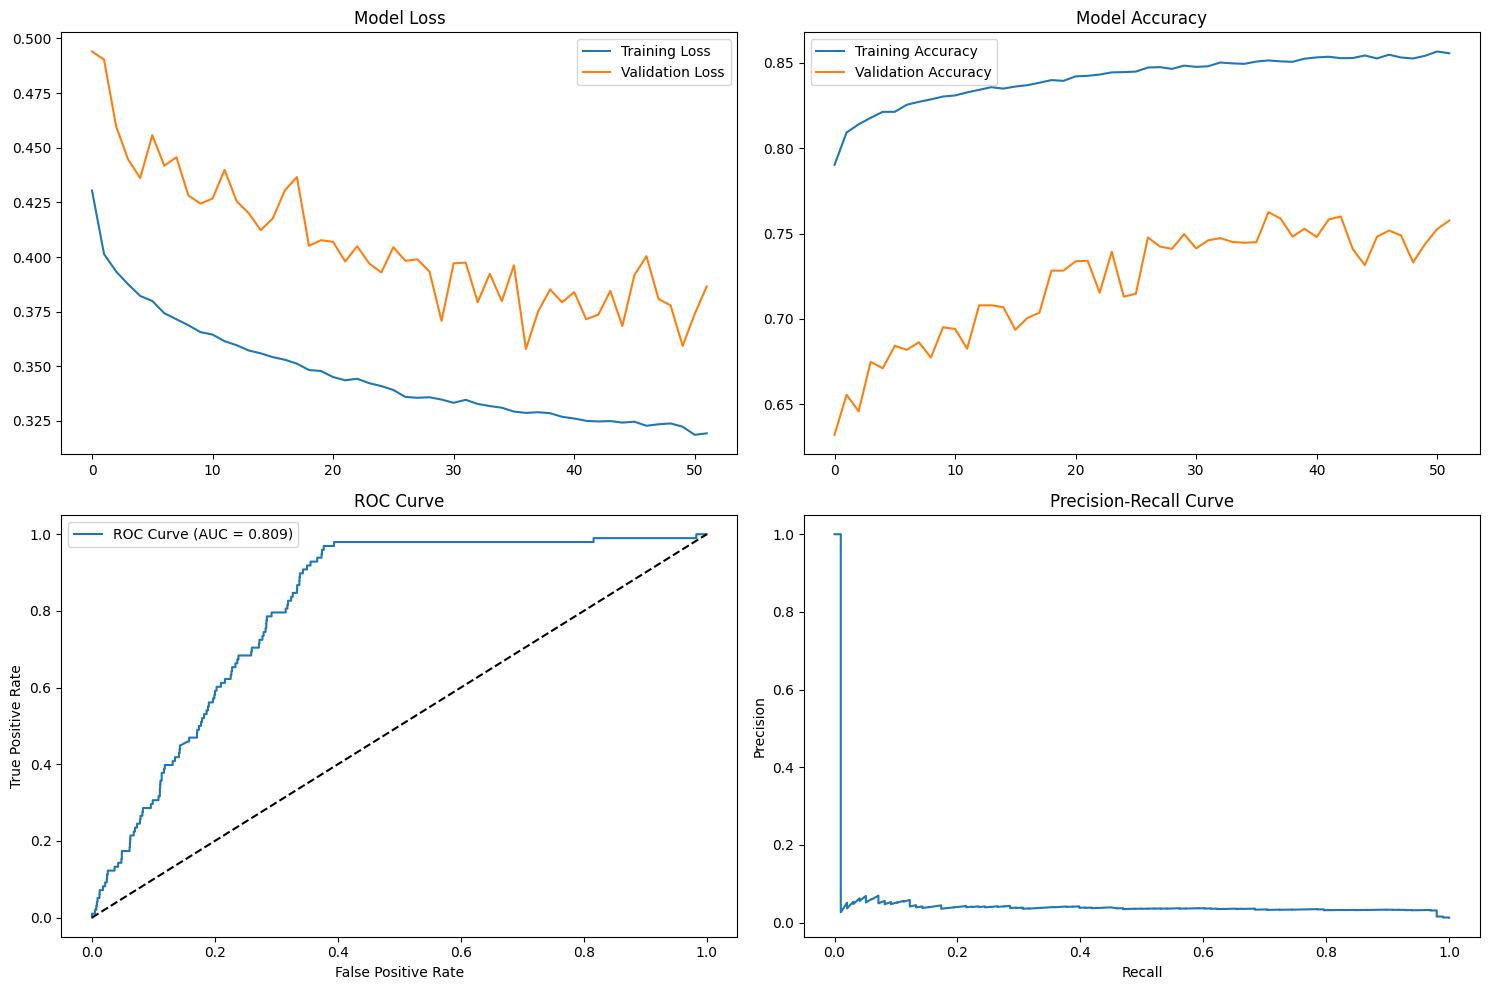


📊 TOP 10 MOST IMPORTANT FEATURES:
 1. noshow_outcomes_count: nan
 2. noshow_outcome_ratio: nan
 3. last_bc_outcome_encoded: 0.1231
 4. showed_up_sc1: 0.0960
 5. engagement_score: 0.0814
 6. outcome_trend: 0.0751
 7. sc1_schedule_to_appointment_days: 0.0679
 8. negative_outcomes_count: 0.0673
 9. first_bc_outcome_encoded: 0.0657
10. total_bc_attempts: 0.0567
✅ Lead Conversion Prediction Pipeline Ready!

Key Functions:
1. prepare_data() - Data prep and train/test split
2. compare_imbalance_methods() - Test SMOTE, SMOTE-Tomek, undersampling
3. train_final_model() - Train final model with best method
4. plot_results() - Visualize training and evaluation metrics


In [41]:


# Assuming your dataframe is called 'df' with features and 'converted' target
# second chat 

df = df_model

def handle_class_imbalance(X_train, y_train, method='smote'):
    """
    Handle class imbalance using different techniques
    """
    print("🔧 Handling Class Imbalance...")
    print(f"Original distribution: {Counter(y_train)}")
    print(f"Conversion rate: {y_train.mean():.3%}")
    
    if method == 'smote':
        # SMOTE - Synthetic Minority Oversampling
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
    elif method == 'smote_tomek':
        # SMOTE + Tomek links (removes borderline cases)
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
        
    elif method == 'undersampling':
        # Random undersampling of majority class
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=42, sampling_strategy=0.3)  # 30% minority class
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        
    print(f"Resampled distribution: {Counter(y_resampled)}")
    print(f"New conversion rate: {y_resampled.mean():.3%}")
    print(f"Dataset size change: {len(X_train)} → {len(X_resampled)}")
    
    return X_resampled, y_resampled

def prepare_data(df, target_col='converted'):
    """
    Basic data preparation and train/test split
    """
    print("📊 Preparing Data...")
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    print(f"Features: {X.shape[1]} columns")
    print(f"Samples: {len(df)}")
    print(f"Conversions: {y.sum()} ({y.mean():.3%})")
    
    # Train/test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def compare_imbalance_methods(X_train, X_test, y_train, y_test):
    """
    Compare different imbalance handling methods
    """
    methods = ['smote', 'smote_tomek', 'undersampling']
    results = {}
    
    for method in methods:
        print(f"\n{'='*50}")
        print(f"Testing {method.upper()}")
        print(f"{'='*50}")
        
        # Handle imbalance
        X_train_resampled, y_train_resampled = handle_class_imbalance(
            X_train, y_train, method=method
        )
        
        # Build simple model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        # Train model
        history = model.fit(
            X_train_resampled, y_train_resampled,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=64,
            verbose=0,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
        )
        
        # Evaluate
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        results[method] = {
            'auc': auc_score,
            'model': model,
            'history': history,
            'predictions': y_pred_proba
        }
        
        print(f"ROC-AUC: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
    return results

def build_neural_network(input_dim, use_class_weights=False, y_train=None):
    """
    Build neural network architecture optimized for imbalanced data
    """
    model = Sequential([
        # Input layer with batch normalization
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Hidden layers with decreasing size
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Calculate class weights if needed
    if use_class_weights and y_train is not None:
        class_weights = {
            0: 1.0,
            1: (len(y_train) - y_train.sum()) / y_train.sum()
        }
        print(f"Class weights: {class_weights}")
    else:
        class_weights = None
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model, class_weights

def train_final_model(X_train, X_test, y_train, y_test, imbalance_method='smote'):
    """
    Train the final model with best performing imbalance handling
    """
    print(f"\n🚀 Training Final Model with {imbalance_method.upper()}")
    print("="*60)
    
    # Handle imbalance
    X_train_resampled, y_train_resampled = handle_class_imbalance(
        X_train, y_train, method=imbalance_method
    )
    
    # Build model
    model, class_weights = build_neural_network(
        input_dim=X_train.shape[1],
        use_class_weights=False  # Already handled by resampling
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            patience=15, 
            restore_best_weights=True, 
            monitor='val_loss'
        )
    ]
    
    # Train model
    history = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# STEP-BY-STEP EXECUTION:

# Step 1: Prepare your data (assuming df is your dataframe with 24 features + CONTRACT_SIGNED)
X_train, X_test, y_train, y_test, scaler = prepare_data(df)

# Step 2: Train model with SMOTE (recommended for 1.2% conversion rate)
final_model, history = train_final_model(X_train, X_test, y_train, y_test, 'smote')

# Step 3: Make predictions and evaluate
predictions = final_model.predict(X_test)
y_pred_binary = (predictions > 0.5).astype(int)

print(f"\n🎯 FINAL RESULTS:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, predictions):.4f}")
print(f"Test Set Size: {len(y_test)} leads")
print(f"Actual Conversions: {y_test.sum()}")
print(f"Predicted Conversions: {y_pred_binary.sum()}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Step 4: Plot results
plot_results(history, y_test, predictions)

# Step 5: Feature importance (optional)
def get_feature_importance(model, feature_names, X_test, y_test, n_top=10):
    """
    Get feature importance using permutation method
    """
    from sklearn.inspection import permutation_importance
    # Convert to sklearn format for permutation importance
    def keras_predict_proba(X):
        return model.predict(X, verbose=0).ravel()
    
    # Calculate baseline score
    baseline_score = roc_auc_score(y_test, keras_predict_proba(X_test))
    
    # Simple feature importance by correlation with target
    feature_corr = []
    for i, feature in enumerate(feature_names):
        corr = np.corrcoef(X_test[:, i], y_test)[0, 1]
        feature_corr.append((feature, abs(corr)))
    
    feature_corr.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n📊 TOP {n_top} MOST IMPORTANT FEATURES:")
    for i, (feature, corr) in enumerate(feature_corr[:n_top]):
        print(f"{i+1:2d}. {feature}: {corr:.4f}")
    
    return feature_corr

# Get feature importance
feature_names = df.drop('converted', axis=1).columns.tolist()
feature_importance = get_feature_importance(final_model, feature_names, X_test, y_test)

def plot_results(history, y_test, predictions):
    """
    Plot training history and evaluation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training history
    axes[0,0].plot(history.history['loss'], label='Training Loss')
    axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,0].set_title('Model Loss')
    axes[0,0].legend()
    
    axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,1].set_title('Model Accuracy')
    axes[0,1].legend()
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    axes[1,0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    axes[1,0].plot([0, 1], [0, 1], 'k--')
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curve')
    axes[1,0].legend()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, predictions)
    axes[1,1].plot(recall, precision)
    axes[1,1].set_xlabel('Recall')
    axes[1,1].set_ylabel('Precision')
    axes[1,1].set_title('Precision-Recall Curve')
    
    plt.tight_layout()
    plt.show()

print("✅ Lead Conversion Prediction Pipeline Ready!")
print("\nKey Functions:")
print("1. prepare_data() - Data prep and train/test split")
print("2. compare_imbalance_methods() - Test SMOTE, SMOTE-Tomek, undersampling")
print("3. train_final_model() - Train final model with best method")
print("4. plot_results() - Visualize training and evaluation metrics")

In [ ]:
# Fix the NaN values in feature importance
print("🔧 CHECKING NaN FEATURES:")
print(f"noshow_outcomes_count unique values: {df['noshow_outcomes_count'].value_counts()}")
print(f"noshow_outcome_ratio unique values: {df['noshow_outcome_ratio'].value_counts()}")

# These might be all zeros or have very little variance
print(f"noshow_outcomes_count variance: {df['noshow_outcomes_count'].var()}")
print(f"noshow_outcome_ratio variance: {df['noshow_outcome_ratio'].var()}")

🔧 CHECKING NaN FEATURES:
noshow_outcomes_count unique values: noshow_outcomes_count
0    38367
Name: count, dtype: int64
noshow_outcome_ratio unique values: noshow_outcome_ratio
0.0    38367
Name: count, dtype: int64
noshow_outcomes_count variance: 0.0
noshow_outcome_ratio variance: 0.0


In [43]:
# Let's run the threshold analysis we discussed
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    precision_score,    # ← add this
    recall_score,       # ← and this
    f1_score            # ← and this
)



predictions = final_model.predict(X_test)

print("\n🎯 OPTIMAL THRESHOLD ANALYSIS:")
print("Threshold | Precision | Recall | F1 | Leads to Call | Efficiency Gain")
print("-" * 70)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    y_pred = (predictions > threshold).astype(int)
    
    if y_pred.sum() > 0:
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        leads_to_call = y_pred.sum()
        efficiency = len(y_test) / leads_to_call
        
        print(f"   {threshold:.1f}    |   {precision:.3f}   |  {recall:.3f}  | {f1:.3f} |     {leads_to_call:4d}      |     {efficiency:.1f}x")

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step

🎯 OPTIMAL THRESHOLD ANALYSIS:
Threshold | Precision | Recall | F1 | Leads to Call | Efficiency Gain
----------------------------------------------------------------------
   0.1    |   0.032   |  0.847  | 0.062 |     2565      |     3.0x
   0.2    |   0.033   |  0.796  | 0.062 |     2398      |     3.2x
   0.3    |   0.034   |  0.796  | 0.065 |     2294      |     3.3x
   0.4    |   0.033   |  0.735  | 0.063 |     2178      |     3.5x
   0.5    |   0.035   |  0.663  | 0.067 |     1854      |     4.1x


In [ ]:
def score_new_leads(new_leads_df, model, scaler, threshold=0.4):
    """
    Score new leads and prioritize high-probability ones
    """
    # Remove the useless no-show features
    features_to_drop = ['noshow_outcomes_count', 'noshow_outcome_ratio']
    X_new = new_leads_df.drop(columns=features_to_drop + ['converted'], errors='ignore')
    
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Get predictions
    probabilities = model.predict(X_new_scaled).ravel()
    
    # Create results dataframe
    results = new_leads_df.copy()
    results['conversion_probability'] = probabilities
    results['high_priority'] = (probabilities >= threshold).astype(int)
    results['priority_rank'] = probabilities.rank(method='dense', ascending=False)
    
    return results.sort_values('conversion_probability', ascending=False)

# Example usage:
# new_scored_leads = score_new_leads(new_leads_df, final_model, scaler, threshold=0.4)
# high_priority_leads = new_scored_leads[new_scored_leads['high_priority'] == 1]
# print(f"High priority leads to call: {len(high_priority_leads)}")

In [ ]:
# to be used with new leads 

new_scored_leads = score_new_leads(new_leads_df, final_model, scaler, threshold=0.4)
high_priority_leads = new_scored_leads[new_scored_leads['high_priority'] == 1]
print(f"High priority leads to call: {len(high_priority_leads)}")

NameError: name 'new_leads_df' is not defined

end of model that includes sc

now attempt without sc, bcs only


In [50]:
# reset df
# now we will drop info of sc and fu

df2 = pd.read_csv(file_path)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38367 entries, 0 to 38366
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       38367 non-null  int64  
 1   LEAD_CREATION_DATE       38367 non-null  object 
 2   SC1_SCHEDULED            7962 non-null   object 
 3   SC1_APPOINTMENT          7962 non-null   object 
 4   LAST_FU                  5495 non-null   object 
 5   NEXT_FU                  2410 non-null   object 
 6   CONTRACT_SIGNED          490 non-null    object 
 7   WITHDRAWAL               81 non-null     object 
 8   IPA_SCHEDULED            426 non-null    object 
 9   IPA_DAY                  375 non-null    object 
 10  MOVED2OPS                288 non-null    object 
 11  NET_TBK                  153 non-null    object 
 12  POST_IPA_CALL            348 non-null    object 
 13  SELF_IPA_PV              0 non-null      float64
 14  SELF_IPA_HP           

In [51]:


def engineer_lead_conversion_features(df):
    """
    Comprehensive feature engineering for lead conversion prediction
    
    Args:
        df: DataFrame with lead data following the specified structure
        
    Returns:
        df_features: DataFrame with engineered features
    """
    
    # Create a copy to avoid modifying original data
    df_features = df.copy()
    
    # Convert date columns to datetime
    date_columns = ['LEAD_CREATION_DATE', 
                  'CONTRACT_SIGNED']
    
    for col in date_columns:
        if col in df_features.columns:
            df_features[col] = pd.to_datetime(df_features[col], errors='coerce')
    
    # BC date columns
    bc_date_cols = [f'BC_{i}' for i in range(1, 19)]
    for col in bc_date_cols:
        if col in df_features.columns:
            df_features[col] = pd.to_datetime(df_features[col], errors='coerce')
    
    # BC outcome columns
    bc_outcome_cols = [f'BC_{i}_OUTCOME' for i in range(1, 19)]
    
    print("Creating booking call efficiency features...")
    
    # 1. BOOKING CALL EFFICIENCY FEATURES
    # Count total BC attempts (non-null BC dates)
    bc_dates = df_features[bc_date_cols].copy()
    df_features['total_bc_attempts'] = bc_dates.notna().sum(axis=1)
    
    # Count total BC outcomes (non-null outcomes)
    bc_outcomes = df_features[bc_outcome_cols].copy()
    df_features['total_bc_outcomes'] = bc_outcomes.notna().sum(axis=1)
    
    # First and last BC attempt dates
    df_features['first_bc_date'] = bc_dates.min(axis=1)
    df_features['last_bc_date'] = bc_dates.max(axis=1)
    
    print("Creating temporal features...")
    
    # 2. TEMPORAL FEATURES
    # Days from lead creation to first BC
    df_features['lead_to_first_bc_days'] = (
        df_features['first_bc_date'] - df_features['LEAD_CREATION_DATE']
    ).dt.days
    
    # Days from first BC to last BC (booking call duration)
    df_features['bc_duration_days'] = (
        df_features['last_bc_date'] - df_features['first_bc_date']
    ).dt.days
    


    # BC call frequency (attempts per day during BC period)
    df_features['bc_frequency'] = np.where(
        df_features['bc_duration_days'] > 0,
        df_features['total_bc_attempts'] / (df_features['bc_duration_days'] + 1),
        df_features['total_bc_attempts']  # If same day, frequency = total attempts
    )
    
    print("Creating engagement quality features...")
    
    # 3. ENGAGEMENT QUALITY FEATURES
    # Define outcome categories
    positive_outcomes = ['VDTOPLAN', 'REACHED', 'CONFIRMED', 'INTERESTED']
    negative_outcomes = ['LOST', 'NOTINTERESTED', 'UNQUALIFIED']
    neutral_outcomes = ['TOBERECALLED', 'RESCHEDULE']
    unreachable_outcomes = ['NOTREACHED', 'NOANSWER', 'VOICEMAIL']
    noshow_outcomes = ['NOSHOW', 'NOSHOWNOTREACHED', 'NOSHOWLOST', 'NOSHOWVDTOPLAN', 'NOSHOWTOBERECALLED']
    
    # Count outcomes by category
    def count_outcome_category(row, category_list):
        count = 0
        for col in bc_outcome_cols:
            if col in row.index and pd.notna(row[col]):
                if any(cat.upper() in str(row[col]).upper() for cat in category_list):
                    count += 1
        return count
    
    df_features['positive_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, positive_outcomes), axis=1
    )
    
    df_features['negative_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, negative_outcomes), axis=1
    )
    
    df_features['noshow_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, noshow_outcomes), axis=1
    )
    
    df_features['unreachable_outcomes_count'] = df_features.apply(
        lambda row: count_outcome_category(row, unreachable_outcomes), axis=1
    )
    
    # Calculate ratios (avoid division by zero)
    total_outcomes = df_features['total_bc_outcomes']
    df_features['positive_outcome_ratio'] = np.where(
        total_outcomes > 0, 
        df_features['positive_outcomes_count'] / total_outcomes, 
        0
    )
    
    df_features['negative_outcome_ratio'] = np.where(
        total_outcomes > 0,
        df_features['negative_outcomes_count'] / total_outcomes,
        0
    )
    
    df_features['noshow_outcome_ratio'] = np.where(
        total_outcomes > 0,
        df_features['noshow_outcomes_count'] / total_outcomes,
        0
    )
    
    df_features['reachability_score'] = np.where(
        total_outcomes > 0,
        1 - (df_features['unreachable_outcomes_count'] / total_outcomes),
        0
    )
    
    print("Creating behavioral pattern features...")
    
    # 4. BEHAVIORAL PATTERN FEATURES
    # Last BC outcome (most recent attempt result)
    def get_last_bc_outcome(row):
        for i in range(18, 0, -1):  # Check from BC_18 down to BC_1
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                return row[col]
        return 'NO_OUTCOME'
    
    df_features['last_bc_outcome'] = df_features.apply(get_last_bc_outcome, axis=1)
    
    # First BC outcome
    def get_first_bc_outcome(row):
        for i in range(1, 19):  # Check from BC_1 to BC_18
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                return row[col]
        return 'NO_OUTCOME'
    
    df_features['first_bc_outcome'] = df_features.apply(get_first_bc_outcome, axis=1)
    
    # Outcome improvement/deterioration pattern
    def outcome_trend(row):
        outcomes = []
        for i in range(1, 19):
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                # Score outcomes (higher = better)
                if any(pos.upper() in str(row[col]).upper() for pos in positive_outcomes):
                    outcomes.append(3)
                elif any(neu.upper() in str(row[col]).upper() for neu in neutral_outcomes):
                    outcomes.append(2)
                elif any(unr.upper() in str(row[col]).upper() for unr in unreachable_outcomes):
                    outcomes.append(1)
                else:
                    outcomes.append(0)  # negative outcomes
        
        if len(outcomes) < 2:
            return 0  # No trend
        
        # Calculate trend (positive = improving, negative = deteriorating)
        return outcomes[-1] - outcomes[0]
    
    df_features['outcome_trend'] = df_features.apply(outcome_trend, axis=1)
    
    # Persistence score (attempts after first negative outcome)
    def persistence_score(row):
        first_negative_pos = None
        total_after_negative = 0
        
        for i in range(1, 19):
            col = f'BC_{i}_OUTCOME'
            if col in row.index and pd.notna(row[col]):
                if first_negative_pos is None and any(neg.upper() in str(row[col]).upper() for neg in negative_outcomes):
                    first_negative_pos = i
                elif first_negative_pos is not None:
                    total_after_negative += 1
        
        return total_after_negative
    
    df_features['persistence_after_negative'] = df_features.apply(persistence_score, axis=1)
    
    print("Creating conversion-related features...")
    
    # 5. CONVERSION-RELATED FEATURES
    # Binary target
    df_features['converted'] = df_features['CONTRACT_SIGNED'].notna().astype(int)
    
 
  
    print("Creating composite scores...")
    
    # 6. COMPOSITE SCORES
    # Overall engagement score (weighted combination)
    df_features['engagement_score'] = (
        0.3 * df_features['positive_outcome_ratio'] + 
        0.2 * df_features['reachability_score'] + 
        0.2 * (1 - df_features['negative_outcome_ratio']) +
        0.1 * (1 - df_features['noshow_outcome_ratio']) +
        0.1 * np.clip(df_features['bc_frequency'], 0, 5) / 5 +  # Cap frequency at 5
        0.1 * np.clip(df_features['outcome_trend'], -3, 3) / 6  # Normalize trend
    )
    
    # Efficiency score (quick to schedule with few attempts)
    df_features['efficiency_score'] = np.where(
        df_features['total_bc_attempts'] > 0,
        1 / (1 + df_features['total_bc_attempts']),  # Inverse of attempts
        0
    )
    
    print("Cleaning up features...")
    
    # Fill NaN values in temporal features
    temporal_features = [
        'lead_to_first_bc_days', 'bc_duration_days', 
        'bc_frequency'
    ]
    
    for feature in temporal_features:
        if feature in df_features.columns:
            df_features[feature] = df_features[feature].fillna(0)
    
    print("Feature engineering completed!")
    
    # Return only the engineered features (remove original columns for cleaner output)
    feature_columns = [
        'ID', 'converted',  # Keep ID and target
        # Booking call efficiency
        'total_bc_attempts', 'total_bc_outcomes',
        # Temporal features
        'lead_to_first_bc_days', 'bc_duration_days', 
        'bc_frequency',
        # Engagement quality
        'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count',
        'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score',
        # Behavioral patterns
        'last_bc_outcome', 'first_bc_outcome', 'outcome_trend', 'persistence_after_negative',
        # Conversion related
    
        # Composite scores
        'engagement_score', 'efficiency_score'
    ]
    
    return df_features[feature_columns]

# Example usage:
# df_features = engineer_lead_conversion_features(df_raw)
# print(f"Created {df_features.shape[1]} features for {df_features.shape[0]} leads")
# print(f"Conversion rate: {df_features['converted'].mean():.3f}")


In [52]:
# Example usage:
df_features = engineer_lead_conversion_features(df2)
print(f"Created {df_features.shape[1]} features for {df_features.shape[0]} leads")
print(f"Conversion rate: {df_features['converted'].mean():.3f}")

# Basic info about what we created
print(f"Shape: {df_features.shape}")
print(f"Conversion rate: {df_features['converted'].mean():.4f}")
print("\nFeature columns:")
print(df_features.columns.tolist())

# Look at basic stats for a few key features
key_features = ['total_bc_attempts', 'total_bc_outcomes', 'engagement_score']

print("Basic statistics for key features:")
print(df_features[key_features].describe())

print(f"\nConversions: {df_features['converted'].sum()} out of {len(df_features)}")

# Compare converters vs non-converters on a few key features
print("Converters vs Non-converters:")
comparison = df_features.groupby('converted')[['total_bc_attempts', 'engagement_score']].mean()
print(comparison)

# Check for missing values and extreme outliers
print("Missing values:")
print(df_features.isnull().sum()[df_features.isnull().sum() > 0])

print("\nFeatures with extreme values to check:")
print("Total BC attempts > 15:", (df_features['total_bc_attempts'] > 15).sum())
print("Engagement score = 0.3 (minimum):", (df_features['engagement_score'] == 0.3).sum())

Creating booking call efficiency features...
Creating temporal features...
Creating engagement quality features...
Creating behavioral pattern features...
Creating conversion-related features...
Creating composite scores...
Cleaning up features...
Feature engineering completed!
Created 20 features for 38367 leads
Conversion rate: 0.013
Shape: (38367, 20)
Conversion rate: 0.0128

Feature columns:
['ID', 'converted', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'last_bc_outcome', 'first_bc_outcome', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score']
Basic statistics for key features:
       total_bc_attempts  total_bc_outcomes  engagement_score
count       38367.000000       38367.000000      38367.000000
mean            

In [53]:
# Check the categorical feature
print("Last BC outcome categories:")
print(df_features['last_bc_outcome'].value_counts().head(10))

print(f"\nTotal unique outcomes: {df_features['last_bc_outcome'].nunique()}")

# Simple approach - let's use label encoding for now
from sklearn.preprocessing import LabelEncoder

# Create a copy to preserve original
df_model = df_features.copy()

# Label encode the categorical feature
le = LabelEncoder()
df_model['last_bc_outcome_encoded'] = le.fit_transform(df_model['last_bc_outcome'])

# Drop the original categorical column
df_model = df_model.drop('last_bc_outcome', axis=1)

print("Label encoding mapping:")
for i, category in enumerate(le.classes_):
    print(f"{i}: {category}")

print(f"\nFinal dataset shape: {df_model.shape}")
print("Columns:", df_model.columns.tolist())

# Encode first_bc_outcome
le_first = LabelEncoder()
df_model['first_bc_outcome_encoded'] = le_first.fit_transform(df_model['first_bc_outcome'])

# Drop the original categorical column
df_model = df_model.drop('first_bc_outcome', axis=1)

print("First BC outcome encoding mapping:")
for i, category in enumerate(le_first.classes_):
    print(f"{i}: {category}")

print(f"\nFinal dataset shape: {df_model.shape}")

Last BC outcome categories:
last_bc_outcome
VDTOPLAN               11738
LOST                    8694
NOMANAGINGAFTERCALL     7108
NO_OUTCOME              3786
NOTINTERESTED           3583
NOTREACHED              1720
PLANNERTOASSIGNNOVD      933
TOBERECALLED             749
1                         53
NEW                        3
Name: count, dtype: int64

Total unique outcomes: 10
Label encoding mapping:
0: 1
1: LOST
2: NEW
3: NOMANAGINGAFTERCALL
4: NOTINTERESTED
5: NOTREACHED
6: NO_OUTCOME
7: PLANNERTOASSIGNNOVD
8: TOBERECALLED
9: VDTOPLAN

Final dataset shape: (38367, 20)
Columns: ['ID', 'converted', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'first_bc_outcome', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 

📊 Preparing Data...
Features: 19 columns
Samples: 38367
Conversions: 490 (1.277%)

🚀 Training Final Model with SMOTE
🔧 Handling Class Imbalance...
Original distribution: Counter({0: 30301, 1: 392})
Conversion rate: 1.277%
Resampled distribution: Counter({0: 30301, 1: 30301})
New conversion rate: 50.000%
Dataset size change: 30693 → 60602

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,209 (55.50 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7863 - loss: 0.4424 - precision: 0.7176 - recall: 0.9440 - val_accuracy: 0.6160 - val_loss: 0.4637 - val_precision: 0.0313 - val_recall: 0.9694
Epoch 2/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8000 - loss: 0.4139 - precision: 0.7220 - recall: 0.9755 - val_accuracy: 0.6220 - val_loss: 0.4777 - val_precision: 0.0317 - val_recall: 0.9694
Epoch 3/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8037 - loss: 0.4075 - precision: 0.7267 - recall: 0.9735 - val_accuracy: 0.6413 - val_loss: 0.4703 - val_precision: 0.0327 - val_recall: 0.9490
Epoch 4/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8078 - loss: 0.4024 - precision: 0.7305 - recall: 0.9754 - val_accuracy: 0.6534 - val_loss: 0.4344 - val_precision: 0.0332 - val_recall: 0.9286
Epoch 5/100
947/947 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8099 - loss: 0.3991 - precision: 0.7318 - recall: 0.9782 - val_accuracy: 0.6620 - val_los

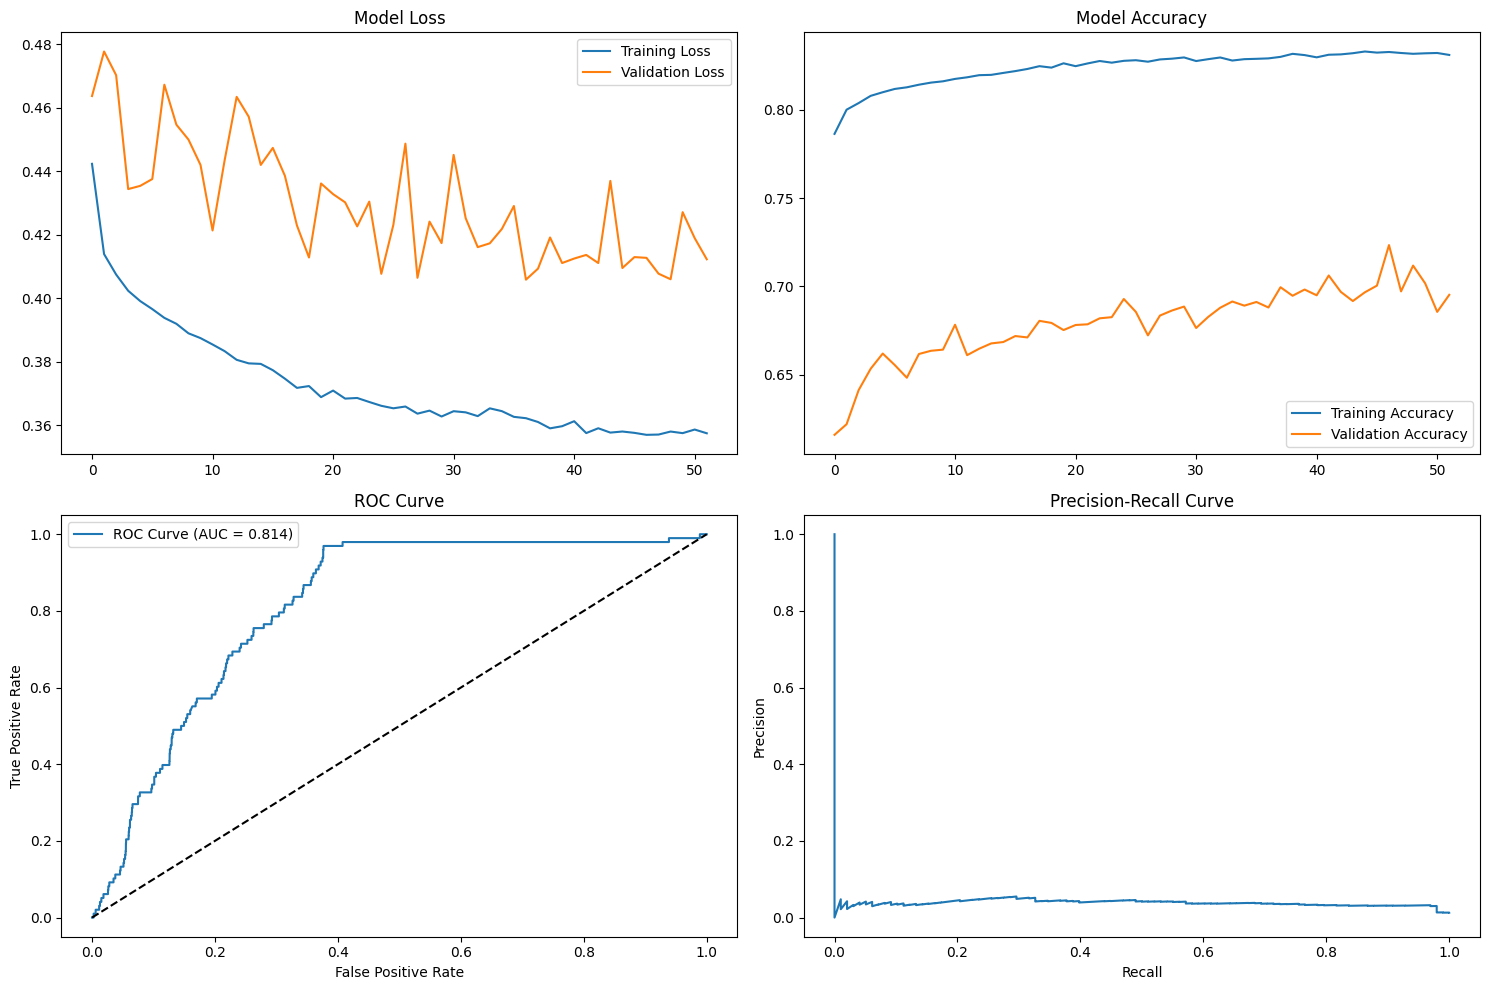


📊 TOP 10 MOST IMPORTANT FEATURES:
 1. noshow_outcomes_count: nan
 2. noshow_outcome_ratio: nan
 3. last_bc_outcome_encoded: 0.1231
 4. engagement_score: 0.0814
 5. outcome_trend: 0.0751
 6. negative_outcomes_count: 0.0673
 7. first_bc_outcome_encoded: 0.0657
 8. total_bc_attempts: 0.0567
 9. total_bc_outcomes: 0.0567
10. positive_outcome_ratio: 0.0473
✅ Lead Conversion Prediction Pipeline Ready!

Key Functions:
1. prepare_data() - Data prep and train/test split
2. compare_imbalance_methods() - Test SMOTE, SMOTE-Tomek, undersampling
3. train_final_model() - Train final model with best method
4. plot_results() - Visualize training and evaluation metrics


In [54]:


# Assuming your dataframe is called 'df' with features and 'converted' target
# second chat 

df = df_model

def handle_class_imbalance(X_train, y_train, method='smote'):
    """
    Handle class imbalance using different techniques
    """
    print("🔧 Handling Class Imbalance...")
    print(f"Original distribution: {Counter(y_train)}")
    print(f"Conversion rate: {y_train.mean():.3%}")
    
    if method == 'smote':
        # SMOTE - Synthetic Minority Oversampling
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
    elif method == 'smote_tomek':
        # SMOTE + Tomek links (removes borderline cases)
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
        
    elif method == 'undersampling':
        # Random undersampling of majority class
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=42, sampling_strategy=0.3)  # 30% minority class
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        
    print(f"Resampled distribution: {Counter(y_resampled)}")
    print(f"New conversion rate: {y_resampled.mean():.3%}")
    print(f"Dataset size change: {len(X_train)} → {len(X_resampled)}")
    
    return X_resampled, y_resampled

def prepare_data(df, target_col='converted'):
    """
    Basic data preparation and train/test split
    """
    print("📊 Preparing Data...")
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    print(f"Features: {X.shape[1]} columns")
    print(f"Samples: {len(df)}")
    print(f"Conversions: {y.sum()} ({y.mean():.3%})")
    
    # Train/test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def compare_imbalance_methods(X_train, X_test, y_train, y_test):
    """
    Compare different imbalance handling methods
    """
    methods = ['smote', 'smote_tomek', 'undersampling']
    results = {}
    
    for method in methods:
        print(f"\n{'='*50}")
        print(f"Testing {method.upper()}")
        print(f"{'='*50}")
        
        # Handle imbalance
        X_train_resampled, y_train_resampled = handle_class_imbalance(
            X_train, y_train, method=method
        )
        
        # Build simple model
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        # Train model
        history = model.fit(
            X_train_resampled, y_train_resampled,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=64,
            verbose=0,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
        )
        
        # Evaluate
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        results[method] = {
            'auc': auc_score,
            'model': model,
            'history': history,
            'predictions': y_pred_proba
        }
        
        print(f"ROC-AUC: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
    return results

def build_neural_network(input_dim, use_class_weights=False, y_train=None):
    """
    Build neural network architecture optimized for imbalanced data
    """
    model = Sequential([
        # Input layer with batch normalization
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        
        # Hidden layers with decreasing size
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Calculate class weights if needed
    if use_class_weights and y_train is not None:
        class_weights = {
            0: 1.0,
            1: (len(y_train) - y_train.sum()) / y_train.sum()
        }
        print(f"Class weights: {class_weights}")
    else:
        class_weights = None
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model, class_weights

def train_final_model(X_train, X_test, y_train, y_test, imbalance_method='smote'):
    """
    Train the final model with best performing imbalance handling
    """
    print(f"\n🚀 Training Final Model with {imbalance_method.upper()}")
    print("="*60)
    
    # Handle imbalance
    X_train_resampled, y_train_resampled = handle_class_imbalance(
        X_train, y_train, method=imbalance_method
    )
    
    # Build model
    model, class_weights = build_neural_network(
        input_dim=X_train.shape[1],
        use_class_weights=False  # Already handled by resampling
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            patience=15, 
            restore_best_weights=True, 
            monitor='val_loss'
        )
    ]
    
    # Train model
    history = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# STEP-BY-STEP EXECUTION:

# Step 1: Prepare your data (assuming df is your dataframe with 24 features + CONTRACT_SIGNED)
X_train, X_test, y_train, y_test, scaler = prepare_data(df)

# Step 2: Train model with SMOTE (recommended for 1.2% conversion rate)
final_model, history = train_final_model(X_train, X_test, y_train, y_test, 'smote')

# Step 3: Make predictions and evaluate
predictions = final_model.predict(X_test)
y_pred_binary = (predictions > 0.5).astype(int)

print(f"\n🎯 FINAL RESULTS:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, predictions):.4f}")
print(f"Test Set Size: {len(y_test)} leads")
print(f"Actual Conversions: {y_test.sum()}")
print(f"Predicted Conversions: {y_pred_binary.sum()}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Step 4: Plot results
plot_results(history, y_test, predictions)

# Step 5: Feature importance (optional)
def get_feature_importance(model, feature_names, X_test, y_test, n_top=10):
    """
    Get feature importance using permutation method
    """
    from sklearn.inspection import permutation_importance
    # Convert to sklearn format for permutation importance
    def keras_predict_proba(X):
        return model.predict(X, verbose=0).ravel()
    
    # Calculate baseline score
    baseline_score = roc_auc_score(y_test, keras_predict_proba(X_test))
    
    # Simple feature importance by correlation with target
    feature_corr = []
    for i, feature in enumerate(feature_names):
        corr = np.corrcoef(X_test[:, i], y_test)[0, 1]
        feature_corr.append((feature, abs(corr)))
    
    feature_corr.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n📊 TOP {n_top} MOST IMPORTANT FEATURES:")
    for i, (feature, corr) in enumerate(feature_corr[:n_top]):
        print(f"{i+1:2d}. {feature}: {corr:.4f}")
    
    return feature_corr

# Get feature importance
feature_names = df.drop('converted', axis=1).columns.tolist()
feature_importance = get_feature_importance(final_model, feature_names, X_test, y_test)

def plot_results(history, y_test, predictions):
    """
    Plot training history and evaluation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training history
    axes[0,0].plot(history.history['loss'], label='Training Loss')
    axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,0].set_title('Model Loss')
    axes[0,0].legend()
    
    axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,1].set_title('Model Accuracy')
    axes[0,1].legend()
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    axes[1,0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
    axes[1,0].plot([0, 1], [0, 1], 'k--')
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curve')
    axes[1,0].legend()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, predictions)
    axes[1,1].plot(recall, precision)
    axes[1,1].set_xlabel('Recall')
    axes[1,1].set_ylabel('Precision')
    axes[1,1].set_title('Precision-Recall Curve')
    
    plt.tight_layout()
    plt.show()

print("✅ Lead Conversion Prediction Pipeline Ready!")
print("\nKey Functions:")
print("1. prepare_data() - Data prep and train/test split")
print("2. compare_imbalance_methods() - Test SMOTE, SMOTE-Tomek, undersampling")
print("3. train_final_model() - Train final model with best method")
print("4. plot_results() - Visualize training and evaluation metrics")

In [55]:
# Fix the NaN values in feature importance
print("🔧 CHECKING NaN FEATURES:")
print(f"noshow_outcomes_count unique values: {df['noshow_outcomes_count'].value_counts()}")
print(f"noshow_outcome_ratio unique values: {df['noshow_outcome_ratio'].value_counts()}")

# These might be all zeros or have very little variance
print(f"noshow_outcomes_count variance: {df['noshow_outcomes_count'].var()}")
print(f"noshow_outcome_ratio variance: {df['noshow_outcome_ratio'].var()}")

# Let's run the threshold analysis we discussed
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    precision_score,    # ← add this
    recall_score,       # ← and this
    f1_score            # ← and this
)



predictions = final_model.predict(X_test)

print("\n🎯 OPTIMAL THRESHOLD ANALYSIS:")
print("Threshold | Precision | Recall | F1 | Leads to Call | Efficiency Gain")
print("-" * 70)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    y_pred = (predictions > threshold).astype(int)
    
    if y_pred.sum() > 0:
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        leads_to_call = y_pred.sum()
        efficiency = len(y_test) / leads_to_call
        
        print(f"   {threshold:.1f}    |   {precision:.3f}   |  {recall:.3f}  | {f1:.3f} |     {leads_to_call:4d}      |     {efficiency:.1f}x")

🔧 CHECKING NaN FEATURES:
noshow_outcomes_count unique values: noshow_outcomes_count
0    38367
Name: count, dtype: int64
noshow_outcome_ratio unique values: noshow_outcome_ratio
0.0    38367
Name: count, dtype: int64
noshow_outcomes_count variance: 0.0
noshow_outcome_ratio variance: 0.0
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

🎯 OPTIMAL THRESHOLD ANALYSIS:
Threshold | Precision | Recall | F1 | Leads to Call | Efficiency Gain
----------------------------------------------------------------------
   0.1    |   0.031   |  0.908  | 0.060 |     2861      |     2.7x
   0.2    |   0.031   |  0.867  | 0.060 |     2753      |     2.8x
   0.3    |   0.031   |  0.837  | 0.059 |     2665      |     2.9x
   0.4    |   0.032   |  0.827  | 0.061 |     2562      |     3.0x
   0.5    |   0.033   |  0.816  | 0.063 |     2456      |     3.1x


no sc and fu also gave good results. we will carry on with that